<a href="https://colab.research.google.com/github/spetznick/applied-gpu-programming/blob/colab-s/assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 2
Explain how the program is compiled and run.
For a vector length of N:

1. How many floating operations are being performed in your vector add kernel?
2. How many global memory reads are being performed by your kernel?

For a vector length of 512:

1. Explain how many CUDA threads and thread blocks you used.
2. Profile your program with Nvidia Nsight. What Achieved Occupancy did you get? You might find https://docs.nvidia.com/nsight-compute/NsightComputeCli/index.html#nvprof-metric-comparison
Links to an external site. useful.

Now increase the vector length to 262140:

1. Did your program still work? If not, what changes did you make?
2. Explain how many CUDA threads and thread blocks you used.
Profile your program with Nvidia Nsight. What Achieved Occupancy do you get now?

Further increase the vector length (try 6-10 different vector length), plot a stacked bar chart showing the breakdown of time including (1) data copy from host to device (2) the CUDA kernel (3) data copy from device to host. For this, you will need to add simple CPU timers to your code regions.





In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Nov 24 12:11:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  7


## First exercise of the second assignment


In [2]:
%%writefile hw2_ex1.cu
#include <stdio.h>
#include <sys/time.h>

#define DataType double

__global__ void vecAdd(DataType *in1, DataType *in2, DataType *out, int len) {
  int myID = blockIdx.x * blockDim.x + threadIdx.x;
  if (myID < len) {
    out[myID] = in1[myID] + in2[myID];
  }
}

// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {
  if (argc < 4) {
    printf("Please provide vector length, thread number, and number of runs as command-line arguments.\n");
    return 1;
  }

  int inputLength = strtol(argv[1], NULL, 10);
  int numThreadsPerBlock = strtol(argv[2], NULL, 10);
  int numRuns = strtol(argv[3], NULL, 10);

  int size = inputLength * sizeof(DataType);
  DataType *hostInput1 = (DataType *)malloc(size);
  DataType *hostInput2 = (DataType *)malloc(size);
  DataType *hostOutput = (DataType *)malloc(size);
  DataType *resultRef = (DataType *)malloc(size);

  // Initialize host inputs with random values
  srand(time(NULL));
  for (int i = 0; i < inputLength; ++i) {
    hostInput1[i] = (DataType)rand() / RAND_MAX;
    hostInput2[i] = (DataType)rand() / RAND_MAX;
  }

  DataType *deviceInput1, *deviceInput2, *deviceOutput;
  cudaMalloc(&deviceInput1, size);
  cudaMalloc(&deviceInput2, size);
  cudaMalloc(&deviceOutput, size);

  dim3 blockDim(numThreadsPerBlock);
  dim3 gridDim((inputLength + blockDim.x - 1) / blockDim.x);
  printf("The input length is %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *kernelTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToDeviceTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToHostTimes = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    // Time data copy to device
    cudaEventRecord(start);
    cudaMemcpy(deviceInput1, hostInput1, size, cudaMemcpyHostToDevice);
    cudaMemcpy(deviceInput2, hostInput2, size, cudaMemcpyHostToDevice);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToDeviceTimes[run], start, stop);

    // Time kernel execution
    cudaEventRecord(start);
    vecAdd<<<gridDim, blockDim>>>(deviceInput1, deviceInput2, deviceOutput, inputLength);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&kernelTimes[run], start, stop);

    // Time data copy back to host
    cudaEventRecord(start);
    cudaMemcpy(hostOutput, deviceOutput, size, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToHostTimes[run], start, stop);
  }

  float meanKernelTime, stdDevKernelTime;
  float meanCopyToDeviceTime, stdDevCopyToDeviceTime;
  float meanCopyToHostTime, stdDevCopyToHostTime;

  calculateMeanAndStdDev(kernelTimes, numRuns, &meanKernelTime, &stdDevKernelTime);
  calculateMeanAndStdDev(copyToDeviceTimes, numRuns, &meanCopyToDeviceTime, &stdDevCopyToDeviceTime);
  calculateMeanAndStdDev(copyToHostTimes, numRuns, &meanCopyToHostTime, &stdDevCopyToHostTime);

  printf("Input length %d, (numBlocks, numThreadsPerBlock) = (%d, %d).\n", inputLength, gridDim.x, blockDim.x);
  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, meanKernelTime, stdDevKernelTime);
  printf("Average time for data copy to device:     %.4f +- %.4f ms\n", meanCopyToDeviceTime, stdDevCopyToDeviceTime);
  printf("Average time for data copy to host:       %.4f +- %.4f ms\n", meanCopyToHostTime, stdDevCopyToHostTime);

  // Error checking and final result comparison
  for (int i = 0; i < inputLength; ++i) {
    resultRef[i] = hostInput1[i] + hostInput2[i];
  }
  for (int i = 0; i < inputLength; ++i) {
    if (abs(resultRef[i] - hostOutput[i]) > 1e-5) {
      printf("Addition wrong at %i: (cpu, gpu) = (%.3f, %.3f)\n", i, resultRef[i], hostOutput[i]);
      break;
    }
  }

  cudaFree(deviceInput1);
  cudaFree(deviceInput2);
  cudaFree(deviceOutput);

  free(hostInput1);
  free(hostInput2);
  free(hostOutput);
  free(resultRef);
  free(kernelTimes);
  free(copyToDeviceTimes);
  free(copyToHostTimes);

  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}


Writing hw2_ex1.cu


## We compile the saved cuda code using nvcc compiler

In [3]:
!nvcc hw2_ex1.cu -o hw2_ex1
!ls

hw2_ex1  hw2_ex1.cu  sample_data


## Finally, we execute the binary of the compiled code

In [4]:
!./hw2_ex1 10 256 1
!./hw2_ex1 10 512 1
!./hw2_ex1 512 256 10
!./hw2_ex1 512 512 10
!./hw2_ex1 512 1024 10
!./hw2_ex1 10000 256 1
!./hw2_ex1 10000 512 1
!./hw2_ex1 10000 1024 1
!./hw2_ex1 100000 256 10
!./hw2_ex1 100000 512 10
!./hw2_ex1 100000 1024 10

Please provide vector length, thread number, and number of runs as command-line arguments.
Please provide vector length, thread number, and number of runs as command-line arguments.
The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 10 runs: 18.8301 +- 56.4603 ms
Average time for data copy to device:     0.1055 +- 0.2522 ms
Average time for data copy to host:       0.0169 +- 0.0049 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 512).
Average kernel execution time of 10 runs: 0.0536 +- 0.1342 ms
Average time for data copy to device:     0.0303 +- 0.0274 ms
Average time for data copy to host:       0.0163 +- 0.0036 ms
The input length is 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Input length 512, (numBlocks, numThreadsPerBlock) = (1, 1024).
Average kernel execution time of 10 runs: 0.0281 

## Vector length 512

In [5]:
!ncu --section "Occupancy" ./hw2_ex1 512 256 1

==PROF== Connected to process 1021 (/content/hw2_ex1)
The input length is 512, (numBlocks, numThreadsPerBlock) = (2, 256).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Input length 512, (numBlocks, numThreadsPerBlock) = (2, 256).
Average kernel execution time of 1 runs: 537.1288 +- 0.0000 ms
Average time for data copy to device:     0.0446 +- 0.0000 ms
Average time for data copy to host:       0.0415 +- 0.0000 ms
==PROF== Disconnected from process 1021
[1021] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (2, 1, 1)x(256, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block           16
    Block Limit Shared Mem                block           16
    Block

## Vector length 262140

In [6]:
!ncu --section "Occupancy" ./hw2_ex1 262140 256 1

==PROF== Connected to process 1060 (/content/hw2_ex1)
The input length is 262140, (numBlocks, numThreadsPerBlock) = (1024, 256).
==PROF== Profiling "vecAdd" - 0: 0%....50%....100% - 1 pass
Input length 262140, (numBlocks, numThreadsPerBlock) = (1024, 256).
Average kernel execution time of 1 runs: 456.4064 +- 0.0000 ms
Average time for data copy to device:     1.2043 +- 0.0000 ms
Average time for data copy to host:       2.3837 +- 0.0000 ms
==PROF== Disconnected from process 1060
[1060] hw2_ex1@127.0.0.1
  vecAdd(double *, double *, double *, int) (1024, 1, 1)x(256, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM                        block           16
    Block Limit Registers                 block           16
    Block Limit Shared Mem                block        

## Experiment with other sizes

In [7]:
!./hw2_ex1 100000 256 10
!./hw2_ex1 1000000 256 10
!./hw2_ex1 10000000 256 10
!./hw2_ex1 100000000 256 10
!./hw2_ex1 500000000 256 10
!./hw2_ex1 1000000000 256 10
!./hw2_ex1 10000000000 256 10

The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0370 +- 0.0603 ms
Average time for data copy to device:     0.4914 +- 0.0696 ms
Average time for data copy to host:       0.3350 +- 0.1659 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1204 +- 0.0587 ms
Average time for data copy to device:     3.9642 +- 0.3816 ms
Average time for data copy to host:       2.9167 +- 1.8480 ms
The input length is 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Input length 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Average kernel execution time of 10 runs: 0.9468 +- 0.0667 ms
Average time for data copy to device:     38.4354 +- 4.3568 ms
Average time for data copy to host:       25.0917 +- 15.9365 ms
The 

   Input Length  Kernel Execution Time (ms)  Copy to Device Time (ms)  \
0        100000                      0.0338                    0.4606   
1       1000000                      0.1145                    3.2693   
2      10000000                      0.9398                   34.1295   
3     100000000                      9.1669                  349.7391   

   Copy to Host Time (ms)  
0                  0.3056  
1                  2.1796  
2                 21.0678  
3                213.4426  


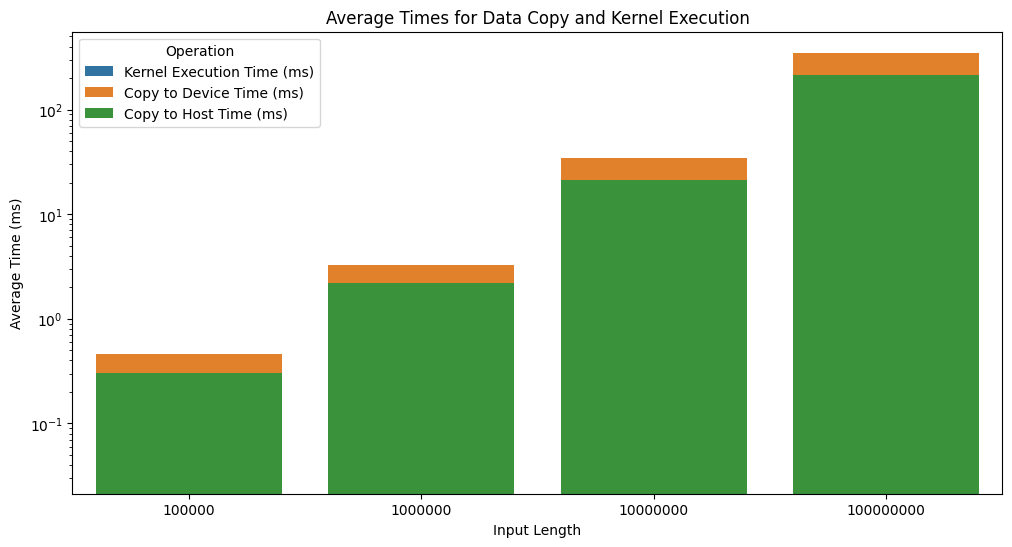

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import pandas as pd

def parse_results(results_str):
    """
    Parses the results of multiple test runs and returns a DataFrame.

    Args:
    - results_str (str): A string containing the test run output.

    Returns:
    - df (pd.DataFrame): A DataFrame containing the parsed results.
    """

    # Regex pattern to match each block of results for a single input length
    pattern = r"The input length is (\d+), \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Input length \d+, \(numBlocks, numThreadsPerBlock\) = \(\d+, \d+\).\s*Average kernel execution time of \d+ runs: ([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to device: +([\d.]+) \+- [\d.]+ ms\s*Average time for data copy to host: +([\d.]+) \+- [\d.]+ ms"

    # Use regex to find all matches in the string
    matches = re.findall(pattern, results_str)

    # Create a list to store the parsed data
    data = []

    # Parse each match and store as a dictionary
    for match in matches:
        input_length = int(match[0])
        kernel_time = float(match[1])
        copy_to_device_time = float(match[2])
        copy_to_host_time = float(match[3])

        # Append the parsed data to the list
        data.append({
            "Input Length": input_length,
            "Kernel Execution Time (ms)": kernel_time,
            "Copy to Device Time (ms)": copy_to_device_time,
            "Copy to Host Time (ms)": copy_to_host_time
        })

    # Convert the data list to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage with the input printout string
results_str = """
The input length is 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Input length 100000, (numBlocks, numThreadsPerBlock) = (391, 256).
Average kernel execution time of 10 runs: 0.0338 +- 0.0579 ms
Average time for data copy to device:     0.4606 +- 0.0284 ms
Average time for data copy to host:       0.3056 +- 0.1264 ms
The input length is 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Input length 1000000, (numBlocks, numThreadsPerBlock) = (3907, 256).
Average kernel execution time of 10 runs: 0.1145 +- 0.0502 ms
Average time for data copy to device:     3.2693 +- 0.1583 ms
Average time for data copy to host:       2.1796 +- 1.2151 ms
The input length is 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Input length 10000000, (numBlocks, numThreadsPerBlock) = (39063, 256).
Average kernel execution time of 10 runs: 0.9398 +- 0.0547 ms
Average time for data copy to device:     34.1295 +- 0.7819 ms
Average time for data copy to host:       21.0678 +- 11.7128 ms
The input length is 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Input length 100000000, (numBlocks, numThreadsPerBlock) = (390625, 256).
Average kernel execution time of 10 runs: 9.1669 +- 0.0574 ms
Average time for data copy to device:     349.7391 +- 15.5713 ms
Average time for data copy to host:       213.4426 +- 116.5841 ms
"""

# Parse the results
df = parse_results(results_str)

# Print the resulting DataFrame
print(df)

# # Data preparation
# data = {
#     "Input Length": [100000, 1000000, 5000000, 10000000, 50000000, 100000000],
#     "Kernel Execution Time (ms)": [0.0332, 0.1134, 0.4788, 0.9397, 4.5879, 9.1720],
#     "Copy to Device Time (ms)": [0.4653, 3.2890, 16.9438, 34.2606, 171.6111, 335.4579],
#     "Copy to Host Time (ms)": [0.3076, 2.1924, 10.8117, 21.0833, 104.4536, 207.1870]
# }

# # Convert the data into a pandas DataFrame
# df = pd.DataFrame(data)

# Reshape the DataFrame for a stacked bar plot
df_melted = df.melt(id_vars="Input Length",
                    value_vars=["Kernel Execution Time (ms)", "Copy to Device Time (ms)", "Copy to Host Time (ms)"],
                    var_name="Operation",
                    value_name="Time (ms)")

# Plotting the stacked bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Input Length", y="Time (ms)", hue="Operation", dodge=False)

# Adding plot details
plt.title("Average Times for Data Copy and Kernel Execution")
plt.xlabel("Input Length")
plt.ylabel("Average Time (ms)")
plt.yscale("log")  # Log scale can help better visualize the differences across large ranges
plt.legend(title="Operation", loc="upper left")

plt.show()


In [2]:
%%writefile hw2_ex2.cu
#include <stdio.h>
#include <sys/time.h>

#define DataType double

// Compute C = A * B each thread computes a single entry
__global__ void gemm(DataType *A, DataType *B, DataType *C, int numARows,
                      int numAColumns, int numBRows, int numBColumns){
  //@@ Insert code to implement matrix multiplication here
  DataType cValue = 0;
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  if (row < numARows && col < numBColumns) {
    for (int i = 0; i < numAColumns; ++i) {
      cValue += A[row * numAColumns + i] * B[i * numBColumns + col];
    }
    C[row * numBColumns + col] = cValue;
  }
}

void printMatrix(const double *matrix, int numRows, int numCols) {
    for (int i = 0; i < numRows; ++i) {
        for (int j = 0; j < numCols; ++j) {
            printf("%8.4f ", matrix[i * numCols + j]);
        }
        printf("\n");
    }
    printf("\n");
}


// Function to calculate mean and standard deviation of an array of floats
void calculateMeanAndStdDev(float *times, int numRuns, float *mean, float *stdDev) {
  float sum = 0.0;
  for (int i = 0; i < numRuns; i++) {
    sum += times[i];
  }
  *mean = sum / numRuns;

  float variance = 0.0;
  for (int i = 0; i < numRuns; i++) {
    variance += (times[i] - *mean) * (times[i] - *mean);
  }
  *stdDev = sqrt(variance / numRuns);
}

int main(int argc, char **argv) {

  DataType *hostA; // The A matrix
  DataType *hostB; // The B matrix
  DataType *hostC; // The output C matrix
  DataType *resultRef; // The reference result
  DataType *deviceA;
  DataType *deviceB;
  DataType *deviceC;
  int numARows;    // number of rows in the matrix A
  int numAColumns; // number of columns in the matrix A
  int numBRows;    // number of rows in the matrix B
  int numBColumns; // number of columns in the matrix B
  int numCRows;
  int numCColumns;
  int numRuns;

  //@@ Insert code below to read in numARows, numAColumns, numBColumns from args
  if (argc < 6) {
    printf("Please provide number of matrix rows and columns of A and B, respectively, and the number of runs as command-line arguments.\n");
    return 1;
  }

  numARows = strtol(argv[1], NULL, 10);
  numAColumns = strtol(argv[2], NULL, 10);
  numBRows = strtol(argv[3], NULL, 10);
  numBColumns = strtol(argv[4], NULL, 10);
  numRuns = strtol(argv[5], NULL, 10);
  numCRows = numARows;
  numCColumns = numBColumns;

  //! Input dim is given as expected by user but internally, B matrix is stored in column-major
  printf("Input matrix dim (%d x %d) (%d x %d) (%d x %d)\n", numARows, numAColumns, numBRows, numBColumns, numCRows, numCColumns);


  //@@ Insert code below to allocate Host memory for input and output
  int sizeA = numAColumns * numARows * sizeof(DataType);
  int sizeB = numBColumns * numBRows * sizeof(DataType);
  int sizeC = numCColumns * numCRows * sizeof(DataType);
  hostA = (DataType *)malloc(sizeA);
  hostB = (DataType *)malloc(sizeB);
  hostC = (DataType *)malloc(sizeC);
  resultRef = (DataType *)malloc(sizeC);


  //@@ Insert code below to initialize hostA and hostB to random numbers, and create reference result in CPU
  srand(time(NULL));
  for (int i = 0; i < numARows * numAColumns; ++i) {
      hostA[i] = (DataType)rand() / RAND_MAX;
  }
  for (int i = 0; i < numBRows * numBColumns; ++i) {
      hostB[i] = (DataType)rand() / RAND_MAX;
  }

  //@@ Insert code below to allocate GPU memory here
  cudaMalloc(&deviceA, sizeA);
  cudaMalloc(&deviceB, sizeB);
  cudaMalloc(&deviceC, sizeC);

  //@@ Initialize the grid and block dimensions here
  // 16x16 should be possible for most architectures
  dim3 blockDim(16, 16);
  dim3 gridDim((numBColumns + blockDim.x - 1) / blockDim.x,
              (numARows + blockDim.y - 1) / blockDim.y);

  // CUDA events for timing
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  float *kernelTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToDeviceTimes = (float *)malloc(numRuns * sizeof(float));
  float *copyToHostTimes = (float *)malloc(numRuns * sizeof(float));

  for (int run = 0; run < numRuns; run++) {
    //@@ Insert code to below to Copy memory to the GPU here
    // Time data copy to device
    cudaEventRecord(start);
    cudaMemcpy(deviceA, hostA, sizeA, cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, hostB, sizeB, cudaMemcpyHostToDevice);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToDeviceTimes[run], start, stop);

    //@@ Launch the GPU Kernel here
    cudaEventRecord(start);
    gemm<<<gridDim, blockDim>>>(deviceA, deviceB, deviceC, numARows,
                      numAColumns, numBRows, numBColumns);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&kernelTimes[run], start, stop);

    //@@ Copy the GPU memory back to the CPU here
    cudaEventRecord(start);
    cudaMemcpy(hostC, deviceC, sizeC, cudaMemcpyDeviceToHost);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&copyToHostTimes[run], start, stop);
  }

  float meanKernelTime, stdDevKernelTime;
  float meanCopyToDeviceTime, stdDevCopyToDeviceTime;
  float meanCopyToHostTime, stdDevCopyToHostTime;

  calculateMeanAndStdDev(kernelTimes, numRuns, &meanKernelTime, &stdDevKernelTime);
  calculateMeanAndStdDev(copyToDeviceTimes, numRuns, &meanCopyToDeviceTime, &stdDevCopyToDeviceTime);
  calculateMeanAndStdDev(copyToHostTimes, numRuns, &meanCopyToHostTime, &stdDevCopyToHostTime);

  printf("Average kernel execution time of %d runs: %.4f +- %.4f ms\n", numRuns, meanKernelTime, stdDevKernelTime);
  printf("Average time for data copy to device:     %.4f +- %.4f ms\n", meanCopyToDeviceTime, stdDevCopyToDeviceTime);
  printf("Average time for data copy to host:       %.4f +- %.4f ms\n", meanCopyToHostTime, stdDevCopyToHostTime);

  //@@ Insert code below to compare the output with the reference
  for (int row = 0; row < numARows; ++row) {
      for (int col = 0; col < numBColumns; ++col) {
          resultRef[row * numBColumns + col] = 0.0;
          for (int k = 0; k < numAColumns; ++k) {
              resultRef[row * numBColumns + col] += hostA[row * numAColumns + k] * hostB[k * numBColumns + col];
          }
      }
  }

  DataType eps = 1e-5;
  for (int i = 0; i < numCRows * numCColumns; ++i) {
    if (fabs(hostC[i] - resultRef[i]) > eps) {
        printf("Result wrong at index %d\n", i);
    }
  }

  //@@ Free the GPU memory here
  cudaFree(deviceA);
  cudaFree(deviceB);
  cudaFree(deviceC);
  //@@ Free the CPU memory here
  free(hostA);
  free(hostB);
  free(hostC);
  free(resultRef);
  free(kernelTimes);
  free(copyToDeviceTimes);
  free(copyToHostTimes);

  // Free timer memory
  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  return 0;
}


Writing hw2_ex2.cu


In [3]:
!nvcc hw2_ex2.cu -o hw2_ex2
!ls

hw2_ex2  hw2_ex2.cu  sample_data


In [11]:
!ncu --section "Occupancy" ./hw2_ex2 64 128 128 64 1

Input matrix dim (64 x 128) (128 x 64) (64 x 64)
==PROF== Connected to process 14981 (/content/hw2_ex2)
==PROF== Profiling "gemm" - 0: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 1: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 2: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 3: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 4: 0%....50%....100% - 1 pass
Average kernel execution time of 5 runs: 57.1837 +- 90.4804 ms
Average time for data copy to device:     0.0850 +- 0.0113 ms
Average time for data copy to host:       0.0453 +- 0.0178 ms
==PROF== Disconnected from process 14981
[14981] hw2_ex2@127.0.0.1
  gemm(double *, double *, double *, int, int, int, int) (4, 4, 1)x(16, 16, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block Limit SM          

In [12]:
!ncu --section "Occupancy" ./hw2_ex2 1024 1023 1023 8193 1

Input matrix dim (1024 x 1023) (1023 x 8193) (1024 x 8193)
==PROF== Connected to process 15020 (/content/hw2_ex2)
==PROF== Profiling "gemm" - 0: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 1: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 2: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 3: 0%....50%....100% - 1 pass
==PROF== Profiling "gemm" - 4: 0%....50%....100% - 1 pass
Average kernel execution time of 5 runs: 249.0322 +- 89.7749 ms
Average time for data copy to device:     18.5715 +- 3.0209 ms
Average time for data copy to host:       23.9275 +- 17.3670 ms
==PROF== Disconnected from process 15020
[15020] hw2_ex2@127.0.0.1
  gemm(double *, double *, double *, int, int, int, int) (513, 64, 1)x(16, 16, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: Occupancy
    ------------------------------- ----------- ------------
    Metric Name                     Metric Unit Metric Value
    ------------------------------- ----------- ------------
    Block L

In [9]:
!./hw2_ex2 4096 1024 1024 1024 5
!./hw2_ex2 8192 1024 1024 1024 5
# !./hw2_ex2 16384 1024 1024 1024 5

!./hw2_ex2 1024 4096 4096 1024 5
!./hw2_ex2 1024 8192 8192 1024 5
# !./hw2_ex2 1024 16384 16384 1024 5

!./hw2_ex2 1024 1024 1024 4096 5
!./hw2_ex2 1024 1024 1024 8192 5
# !./hw2_ex2 1024 1024 1024 16384 5

Input matrix dim (4096 x 1024) (1024 x 1024) (4096 x 1024)
Average kernel execution time of 5 runs: 67.7541 +- 23.8906 ms
Average time for data copy to device:     8.9831 +- 0.0746 ms
Average time for data copy to host:       10.8980 +- 7.0220 ms
Input matrix dim (8192 x 1024) (1024 x 1024) (8192 x 1024)
Average kernel execution time of 5 runs: 107.8700 +- 42.0360 ms
Average time for data copy to device:     16.2604 +- 0.2504 ms
Average time for data copy to host:       21.9617 +- 14.7405 ms
Input matrix dim (1024 x 4096) (4096 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 74.2851 +- 25.2475 ms
Average time for data copy to device:     14.4156 +- 0.1687 ms
Average time for data copy to host:       2.7686 +- 1.7391 ms
Input matrix dim (1024 x 8192) (8192 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 103.1956 +- 34.5241 ms
Average time for data copy to device:     28.8371 +- 0.4884 ms
Average time for data copy to host:       2.8023 +- 1.6971 ms
Input ma

Input matrix dim (1024 x 1024) (1024 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 23.6280 +- 0.4713 ms
Average time for data copy to device:     3.7530 +- 0.0899 ms
Average time for data copy to host:       2.7388 +- 1.7618 ms
Input matrix dim (2048 x 1024) (1024 x 2048) (2048 x 2048)
Average kernel execution time of 5 runs: 62.0676 +- 20.9948 ms
Average time for data copy to device:     7.4424 +- 0.3352 ms
Average time for data copy to host:       10.8247 +- 7.2729 ms
Input matrix dim (8192 x 1024) (1024 x 1024) (8192 x 1024)
Average kernel execution time of 5 runs: 111.5458 +- 39.9013 ms
Average time for data copy to device:     17.4750 +- 1.4376 ms
Average time for data copy to host:       23.6000 +- 12.9207 ms
Input matrix dim (1024 x 8192) (8192 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 110.6401 +- 32.9280 ms
Average time for data copy to device:     28.6928 +- 0.2800 ms
Average time for data copy to host:       2.7938 +- 1.7347 ms
Input matrix dim (1024 x 1024) (1024 x 8192) (1024 x 8192)
Average kernel execution time of 5 runs: 106.5064 +- 40.3511 ms
Average time for data copy to device:     16.9968 +- 0.4473 ms
Average time for data copy to host:       24.6445 +- 19.0044 ms

  Matrix A Dimensions Matrix B Dimensions Matrix C Dimensions  \
0           1024x1024           1024x1024           1024x1024   
1           2048x1024           1024x2048           2048x2048   
2           8192x1024           1024x1024           8192x1024   
3           1024x8192           8192x1024           1024x1024   

   Kernel Execution Time (ms)  Copy to Device Time (ms)  \
0                     23.6280                    3.7530   
1                     62.0676                    7.4424   
2                    111.5458                   17.4750   
3                    110.6401                   28.6928   

   Copy to Host Time (ms)  
0                  2.7388  
1                 10.8247  
2                 23.6000  
3                  2.7938  


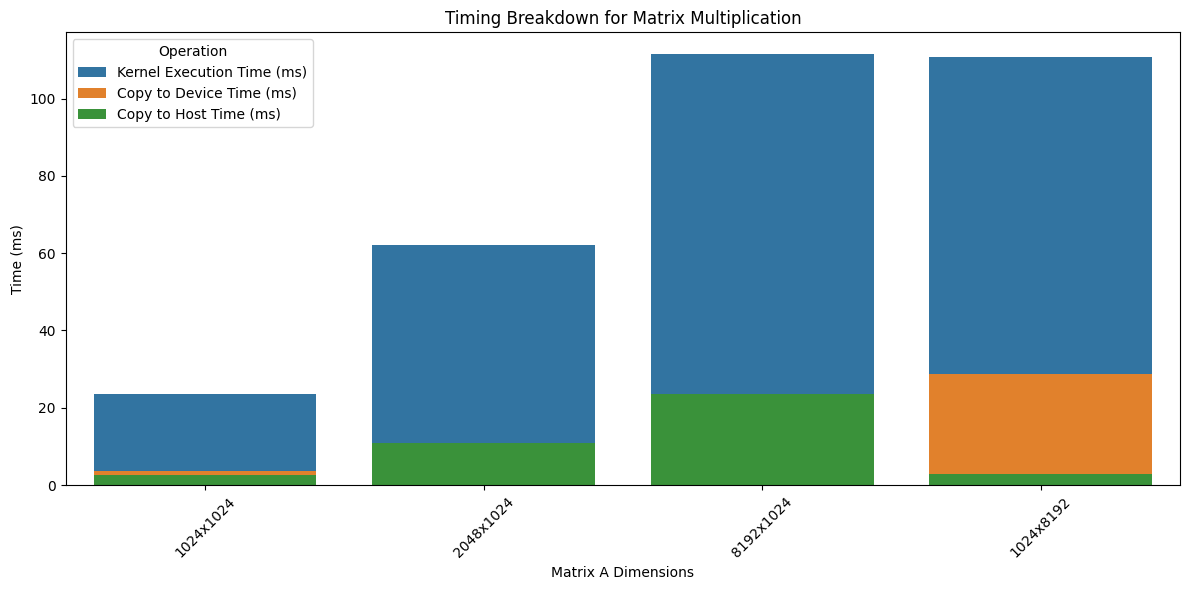

In [10]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def parse_results(results_str):
    """
    Parses the matrix timing results and returns a DataFrame.

    Args:
    - results_str (str): The string containing the test run output.

    Returns:
    - pd.DataFrame: A DataFrame containing the parsed results.
    """
    # Regex pattern to capture matrix dimensions and timing information
    pattern = (
        r"Input matrix dim \((\d+) x (\d+)\) \((\d+) x (\d+)\) \((\d+) x (\d+)\)\n"
        r"Average kernel execution time of \d+ runs: ([\d.]+) \+- [\d.]+ ms\n"
        r"Average time for data copy to device:\s+([\d.]+) \+- [\d.]+ ms\n"
        r"Average time for data copy to host:\s+([\d.]+) \+- [\d.]+ ms"
    )

    # Find all matches
    matches = re.findall(pattern, results_str)

    # Parse the data into a list of dictionaries
    data = []
    for match in matches:
        numARows, numACols, numBRows, numBCols, numCRows, numCCols = map(int, match[:6])
        kernel_time = float(match[6])
        copy_to_device_time = float(match[7])
        copy_to_host_time = float(match[8])

        data.append({
            "Matrix A Dimensions": f"{numARows}x{numACols}",
            "Matrix B Dimensions": f"{numBRows}x{numBCols}",
            "Matrix C Dimensions": f"{numCRows}x{numCCols}",
            "Kernel Execution Time (ms)": kernel_time,
            "Copy to Device Time (ms)": copy_to_device_time,
            "Copy to Host Time (ms)": copy_to_host_time
        })

    return pd.DataFrame(data)


results_str = """
Input matrix dim (4096 x 1024) (1024 x 1024) (4096 x 1024)
Average kernel execution time of 5 runs: 67.7541 +- 23.8906 ms
Average time for data copy to device:     8.9831 +- 0.0746 ms
Average time for data copy to host:       10.8980 +- 7.0220 ms
Input matrix dim (8192 x 1024) (1024 x 1024) (8192 x 1024)
Average kernel execution time of 5 runs: 107.8700 +- 42.0360 ms
Average time for data copy to device:     16.2604 +- 0.2504 ms
Average time for data copy to host:       21.9617 +- 14.7405 ms
Input matrix dim (1024 x 4096) (4096 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 74.2851 +- 25.2475 ms
Average time for data copy to device:     14.4156 +- 0.1687 ms
Average time for data copy to host:       2.7686 +- 1.7391 ms
Input matrix dim (1024 x 8192) (8192 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 103.1956 +- 34.5241 ms
Average time for data copy to device:     28.8371 +- 0.4884 ms
Average time for data copy to host:       2.8023 +- 1.6971 ms
Input matrix dim (1024 x 1024) (1024 x 4096) (1024 x 4096)
Average kernel execution time of 5 runs: 68.1598 +- 22.4529 ms
Average time for data copy to device:     9.1076 +- 0.1012 ms
Average time for data copy to host:       11.0525 +- 7.7992 ms
Input matrix dim (1024 x 1024) (1024 x 8192) (1024 x 8192)
Average kernel execution time of 5 runs: 110.2981 +- 40.3987 ms
Average time for data copy to device:     16.6405 +- 0.4797 ms
Average time for data copy to host:       21.1252 +- 13.5579 ms
"""

# Parse the results
df = parse_results(results_str)

# Print the parsed DataFrame
print(df)

# Reshape the DataFrame for a stacked bar plot
df_melted = df.melt(
    id_vars=["Matrix A Dimensions", "Matrix B Dimensions", "Matrix C Dimensions"],
    value_vars=["Kernel Execution Time (ms)", "Copy to Device Time (ms)", "Copy to Host Time (ms)"],
    var_name="Operation",
    value_name="Time (ms)"
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_melted,
    x="Matrix A Dimensions",
    y="Time (ms)",
    hue="Operation",
    dodge=False
)

# Adding plot details
plt.title("Timing Breakdown for Matrix Multiplication")
plt.xlabel("Matrix A Dimensions")
plt.ylabel("Time (ms)")
# plt.yscale("log")  # Log scale for better? visualization of differences
plt.legend(title="Operation", loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

                       Matrix Configurations                   Operation  \
0   A: 4096x1024\nB: 1024x1024\nC: 4096x1024    Copy to Device Time (ms)   
1   A: 8192x1024\nB: 1024x1024\nC: 8192x1024    Copy to Device Time (ms)   
2   A: 1024x4096\nB: 4096x1024\nC: 1024x1024    Copy to Device Time (ms)   
3   A: 1024x8192\nB: 8192x1024\nC: 1024x1024    Copy to Device Time (ms)   
4   A: 1024x1024\nB: 1024x4096\nC: 1024x4096    Copy to Device Time (ms)   
5   A: 1024x1024\nB: 1024x8192\nC: 1024x8192    Copy to Device Time (ms)   
6   A: 4096x1024\nB: 1024x1024\nC: 4096x1024      Copy to Host Time (ms)   
7   A: 8192x1024\nB: 1024x1024\nC: 8192x1024      Copy to Host Time (ms)   
8   A: 1024x4096\nB: 4096x1024\nC: 1024x1024      Copy to Host Time (ms)   
9   A: 1024x8192\nB: 8192x1024\nC: 1024x1024      Copy to Host Time (ms)   
10  A: 1024x1024\nB: 1024x4096\nC: 1024x4096      Copy to Host Time (ms)   
11  A: 1024x1024\nB: 1024x8192\nC: 1024x8192      Copy to Host Time (ms)   
12  A: 4096x

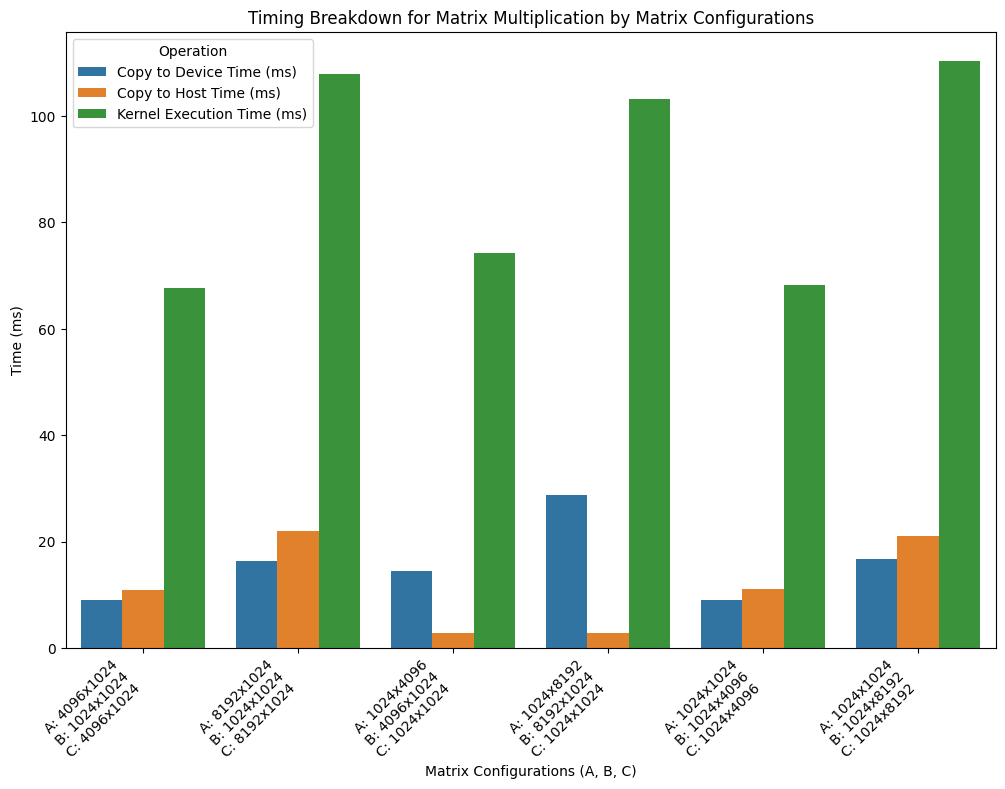

In [6]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def parse_results(results_str):
    """
    Parses the matrix timing results and returns a DataFrame.

    Args:
    - results_str (str): The string containing the test run output.

    Returns:
    - pd.DataFrame: A DataFrame containing the parsed results.
    """
    # Regex pattern to capture matrix dimensions and timing information
    pattern = (
        r"Input matrix dim \((\d+) x (\d+)\) \((\d+) x (\d+)\) \((\d+) x (\d+)\)\n"
        r"Average kernel execution time of \d+ runs: ([\d.]+) \+- [\d.]+ ms\n"
        r"Average time for data copy to device:\s+([\d.]+) \+- [\d.]+ ms\n"
        r"Average time for data copy to host:\s+([\d.]+) \+- [\d.]+ ms"
    )

    # Find all matches
    matches = re.findall(pattern, results_str)

    # Parse the data into a list of dictionaries
    data = []
    for match in matches:
        numARows, numACols, numBRows, numBCols, numCRows, numCCols = map(int, match[:6])
        kernel_time = float(match[6])
        copy_to_device_time = float(match[7])
        copy_to_host_time = float(match[8])

        data.append({
            "Matrix A Dimensions": f"{numARows}x{numACols}",
            "Matrix B Dimensions": f"{numBRows}x{numBCols}",
            "Matrix C Dimensions": f"{numCRows}x{numCCols}",
            "Kernel Execution Time (ms)": kernel_time,
            "Copy to Device Time (ms)": copy_to_device_time,
            "Copy to Host Time (ms)": copy_to_host_time
        })

    return pd.DataFrame(data)


results_str = """
Input matrix dim (4096 x 1024) (1024 x 1024) (4096 x 1024)
Average kernel execution time of 5 runs: 67.7541 +- 23.8906 ms
Average time for data copy to device:     8.9831 +- 0.0746 ms
Average time for data copy to host:       10.8980 +- 7.0220 ms
Input matrix dim (8192 x 1024) (1024 x 1024) (8192 x 1024)
Average kernel execution time of 5 runs: 107.8700 +- 42.0360 ms
Average time for data copy to device:     16.2604 +- 0.2504 ms
Average time for data copy to host:       21.9617 +- 14.7405 ms
Input matrix dim (1024 x 4096) (4096 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 74.2851 +- 25.2475 ms
Average time for data copy to device:     14.4156 +- 0.1687 ms
Average time for data copy to host:       2.7686 +- 1.7391 ms
Input matrix dim (1024 x 8192) (8192 x 1024) (1024 x 1024)
Average kernel execution time of 5 runs: 103.1956 +- 34.5241 ms
Average time for data copy to device:     28.8371 +- 0.4884 ms
Average time for data copy to host:       2.8023 +- 1.6971 ms
Input matrix dim (1024 x 1024) (1024 x 4096) (1024 x 4096)
Average kernel execution time of 5 runs: 68.1598 +- 22.4529 ms
Average time for data copy to device:     9.1076 +- 0.1012 ms
Average time for data copy to host:       11.0525 +- 7.7992 ms
Input matrix dim (1024 x 1024) (1024 x 8192) (1024 x 8192)
Average kernel execution time of 5 runs: 110.2981 +- 40.3987 ms
Average time for data copy to device:     16.6405 +- 0.4797 ms
Average time for data copy to host:       21.1252 +- 13.5579 ms
"""

# Parse the results
df = parse_results(results_str)

# Create a new column that combines matrix dimensions for A, B, and C
df["Matrix Configurations"] = (
    "A: " + df["Matrix A Dimensions"] + "\n" +
    "B: " + df["Matrix B Dimensions"] + "\n" +
    "C: " + df["Matrix C Dimensions"]
)

# Reshape the DataFrame for a stacked bar plot
df_melted = df.melt(
    id_vars=["Matrix Configurations"],
    value_vars=["Copy to Device Time (ms)", "Copy to Host Time (ms)", "Kernel Execution Time (ms)"],
    var_name="Operation",
    value_name="Time (ms)"
)
print(df_melted)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_melted,
    x="Matrix Configurations",
    y="Time (ms)",
    hue="Operation",
    dodge=True
)

# Adding plot details
plt.title("Timing Breakdown for Matrix Multiplication by Matrix Configurations")
plt.xlabel("Matrix Configurations (A, B, C)")
plt.ylabel("Time (ms)")
plt.legend(title="Operation", loc="upper left")
plt.xticks(rotation=45, ha="right")
# plt.tight_layout()

plt.show()



1. Name three applications domains of matrix multiplication.
2. How many floating operations are being performed in your matrix multiply kernel?
3. How many global memory reads are being performed by your kernel?  
4. For a matrix A of (64x128) and B of (128x64):
  - Explain how many CUDA threads and thread blocks you used.
  - Profile your program with Nvidia Nsight. What Achieved Occupancy did you get?
5. For a matrix A of (1024x1023) and B of (1023x8193):
  - Did your program still work? If not, what changes did you make?
  - Explain how many CUDA threads and thread blocks you used.
  - Profile your program with Nvidia Nsight. What Achieved Occupancy do you get now?
6. Further increase the size of matrix A and B, plot a stacked bar chart showing the breakdown of time including (1) data copy from host to device (2) the CUDA kernel (3) data copy from device to host. For this, you will need to add simple CPU timers to your code regions. Explain what you observe.
7. Now, change DataType from double to float, re-plot the a stacked bar chart showing the time breakdown. Explain what you observe.
